# Exploring GIS Data for Correlations

This notebook covers the basic exploratory steps every data science project undertakes when the focus is on understanding the character of your data.  In this case, we are looking for correlations in the change detection data from GIS analysis and price data.  The original source of the data, including biases and collection parameters, are unknown at the time of this writing. 

**Main Takeaway**:  We prove that we do not have strong evidence to suggest there is a correlation between the GIS Change detection and Iron ore price data. However, further analysis is required.

First, let's PROVE the test we're going to do so you believe me.



## Demonstrating the Correlation Test

To "make you a believer" in the correlation test we will perform, I'll demonstrate the technique on two values that are known to correlate: the <a href="https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average" target="_blank">Dow Jones Industrial Average</a> and the <a href="https://en.wikipedia.org/wiki/S%26P_500_Index" target="_blank">Standard & Poors (S&P) 500</a>.  This picture shows the two indexes tracking each other; when one is down, the other is down and vice versa:

<div class="image">
<img src="http://neutrongroup.cachefly.net/wss.blog/records/chart.png" height="600" width="700">
<p><center><font face="verdana" color="green" font size=1>This is a graph of a normal distribution</font></center></p>
</div>

To prepare our data for correlation tests, we use the <a href="https://svds.com/avoiding-common-mistakes-with-time-series/" target="_blank">first differencing</a> method to create a stationary time series.  Since we **KNOW** the S&P and Dow are correlated, we expect a **HIGH** positive score.  For details on how to interpret the correlation coefficients, <a href="http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/" target="_blank">read this great article from MiniTab</a>. 

To start, I get the <a href="https://finance.yahoo.com/quote/%5EGSPC/history?period1=1354770000&period2=1512536400&interval=1d&filter=history&frequency=1d" target="_blank">historical prices of the S&P 500</a> and the <a href="https://finance.yahoo.com/quote/%5EDJI/history?period1=1354770000&period2=1512536400&interval=1d&filter=history&frequency=1d" target="_blank">prices of the Dow Jones</a> from Yahoo Finance, download to csvs, and load into <a href="https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe" target="_blank">`python pandas` dataframes</a>.  After using the differencing method, I just create the correlation matrix.  For a quick tip on interpretation of our test:
*  Numbers closer to 1 imply a strong positive correlation
*  Numbers closer to -1 imply a strong negative correlation
*  Numbers in the middle are moderate, increasing or decreasing as the numbers move up or down the scale
*  Being closer to zero implies there is **no** correlation.  

So, we expect the **Dow** and **S&P** to be close to one (1).  Let's see if data gives us the expected answer:

In [233]:
# loading the data for dow and sp500
sp=pd.read_csv('/Users/linwood/Downloads/sp500.csv')
dow=pd.read_csv('/Users/linwood/Downloads/dowjones.csv')
sp = sp.assign(Date=pd.to_datetime(sp['Date'])).set_index('Date').resample('M').mean().rename(columns={0:'Sp500'})
dow = dow.assign(Date=pd.to_datetime(dow['Date'])).set_index('Date').resample('M').mean().rename(columns={0:'Dow Jones'})

Let's plot the data to show visually how they track each other.

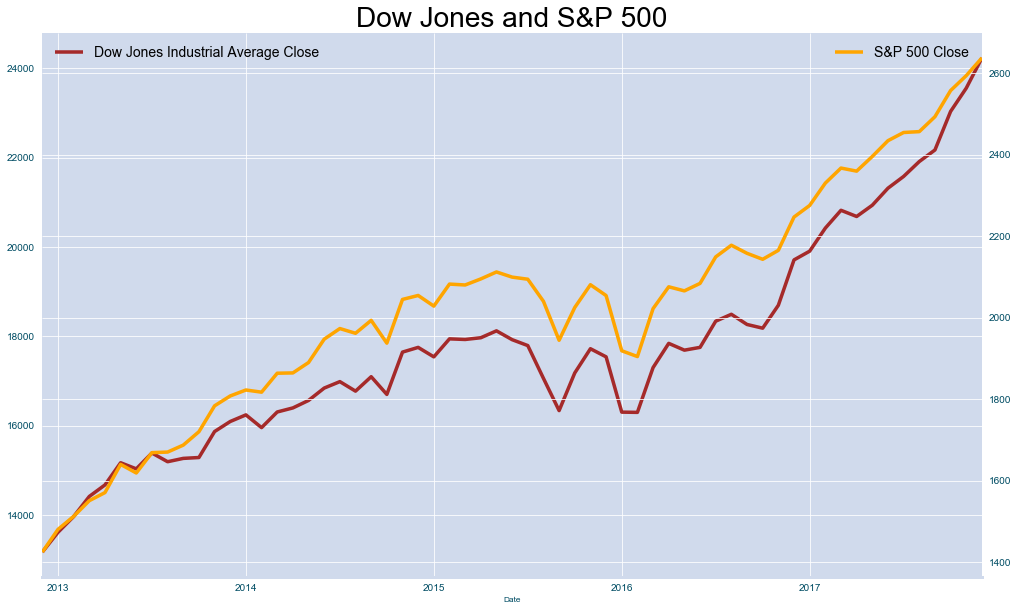

In [234]:


###################
# first plot
###################
f,ax=plt.subplots(figsize=(15,10))
dow.Close.plot(label='Dow Jones Industrial Average Close',color='brown',linewidth=3.5,ax=ax)
plt.legend(fontsize=14,loc=2)
###################
# second plot
###################
ax2 = ax.twinx()

sp['Close'].plot(label='S&P 500 Close',color='orange',linewidth=3.5,ax=ax2)
plt.legend(fontsize=14)
plt.title('Dow Jones and S&P 500',fontsize=28)
plt.show()

And now we perform the differencing method:

In [235]:
# differencing for the sp500
spMag= (sp.assign(diff=sp.Close.diff().fillna(0))).apply(lambda x: (x['diff']/x['Close']),axis=1).rename(columns={0:"SP500 Differences"})

# differecnign for the dow
dowMag= (dow.assign(diff=dow.Close.diff().fillna(0))).apply(lambda x: (x['diff']/x['Close']),axis=1).rename(columns={0:"Dow Jones Differences"})


And get out correlation matrix:

In [236]:
pd.concat([spMag,dowMag],axis=1).dropna().corr().rename(columns={0:"SP500 Differences"})

,SP500 Differences,1
0,1.000000,0.952485
1,0.952485,1.000000


Looking at the simple matrix above, we see the two have a **STRONG POSITIVE** correlation (see 0.952485).  So, now that you believe my test, let's run the test on our data!

## Running the Test on Our Data

The first step is covering the basic summary statistics to describe our data.  Before all that, we load the data into a <a href="https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe" target="_blank">`pandas dataframe`</a>

In [237]:
import pandas as pd
import numpy as np
import matplotlib as mpl

mpl.style.use('economist')

# read in excel file, set time as index, sort data by time
df = pd.read_excel('./GlobalIronOre.xlsx',sheetname=1,index=False)\
.set_index('Date').sort_index()

Let's examine the first few rows:

In [238]:
df.head(10)

,system:index,Number,Area M2,Port Number,description,id,orbit,port,time,val,yard,Delta*Area,Sum*Area2,True,year,month,Ore Price
Date,,,,,,,,,,,,,,,,,
2015-02-23 00:55:11.611,41_0,2558,65340.152999,8,NaN,41,136,Marmugao,1424739311611,-8.168024,40,381.277440,0.000000,0.0,2015.0,2.0,NaN
2015-02-23 00:55:11.611,40_0,1467,70462.318864,8,NaN,40,136,Marmugao,1424739311611,-8.064268,39,53020.848484,0.000000,0.0,2015.0,2.0,NaN
2015-03-18 17:25:48.932,45_0,2351,71088.703524,9,NaN,45,131,saldanha,1426785948932,-7.065946,44,311559.753139,0.000000,0.0,2015.0,3.0,NaN
2015-03-18 17:25:48.932,43_0,2045,71582.270528,9,NaN,43,131,saldanha,1426785948932,-7.146044,42,181780.330878,0.000000,0.0,2015.0,3.0,NaN
2015-03-18 17:25:48.932,42_0,1943,60584.251394,9,NaN,42,131,saldanha,1426785948932,-7.566986,41,45558.576848,0.000000,0.0,2015.0,3.0,NaN
2015-03-18 17:25:48.932,44_0,2147,75888.314918,9,NaN,44,131,saldanha,1426785948932,-7.686115,43,140759.642120,0.000000,0.0,2015.0,3.0,NaN
2015-03-18 17:25:48.932,46_0,2249,81694.503738,9,NaN,46,131,saldanha,1426785948932,-9.055479,45,133030.729016,0.000000,0.0,2015.0,3.0,NaN
2015-03-30 17:25:49.203,42_1,1944,60584.251394,9,NaN,42,131,saldanha,1427822749203,-7.675738,41,6588.651060,6588.651060,1.0,2015.0,3.0,NaN
2015-03-30 17:25:49.203,46_1,2250,81694.503738,9,NaN,46,131,saldanha,1427822749203,-9.184596,45,10548.108131,10548.108131,1.0,2015.0,3.0,NaN


Quickly, we can get the summary stats to see things like median, mean, quantiles, etc.  

In [239]:
# basic summary stats for numeric values
df.describe()

/Users/linwood/anaconda3/envs/scipyML/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,Number,Area M2,Port Number,description,id,orbit,time,val,yard,Delta*Area,Sum*Area2,True,year,month,Ore Price
count,2878.000000,2.878000e+03,2878.000000,0.0,2878.000000,2878.000000,2.878000e+03,2878.000000,2878.000000,2.870000e+03,2.877000e+03,2877.000000,2877.000000,2877.000000,0.0
mean,1438.500000,1.514487e+05,4.686240,NaN,24.030924,96.061501,1.480313e+12,-8.031953,23.030924,1.411408e+05,1.377179e+05,0.984706,2016.384776,6.780327,NaN
std,830.951362,1.519097e+05,2.775687,NaN,13.969332,44.656002,2.270849e+10,1.991415,13.969332,1.713477e+05,1.697469e+05,0.122740,0.732480,3.405447,NaN
min,0.000000,3.135515e+04,1.000000,NaN,2.000000,24.000000,1.424739e+12,-15.450349,1.000000,1.739038e+01,0.000000e+00,0.000000,2015.000000,1.000000,NaN
25%,719.250000,6.591800e+04,2.000000,NaN,11.000000,61.000000,1.463584e+12,-9.303987,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1438.500000,1.174650e+05,5.000000,NaN,25.000000,82.000000,1.484948e+12,-8.183148,24.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2157.750000,1.585192e+05,6.000000,NaN,35.000000,136.000000,1.498551e+12,-6.937222,34.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,2877.000000,1.050635e+06,9.000000,NaN,46.000000,163.000000,1.511473e+12,0.000000,45.000000,1.842478e+06,1.842478e+06,1.000000,2017.000000,12.000000,NaN


## Getting Other Data

Data analysis is all about comparison and context.  In this case, we want to examine the changes in other data to see if it correlates with our original data.  The first comparison is Iron Ore prices per metric ton.  <a href="http://www.indexmundi.com/commodities/?commodity=iron-ore&months=360" target="_blank">One site had historical data</a>, so we strip the HTML table and convert it to a clean, tabular data set. To save space I'm performing a few data cleaning steps in a single line to clean and index the data.

In [240]:
# Iron Ore prices data
ore_30yrs= pd.read_html('http://www.indexmundi.com/commodities/?commodity=iron-ore&months=360',
                        skiprows=1,
                        header=0)[0].iloc[:-2,:3]
ore_30yrs = ore_30yrs.assign(Month=pd.to_datetime(ore_30yrs.Month)+pd.offsets.MonthEnd(0))\
.set_index('Month').rename(columns={'Price':'orePrice'})
ore_30yrs.head()

,orePrice,Change
Month,,
1987-11-30,25.3,-
1987-12-31,25.3,0.00 %
1988-01-31,24.3,-3.95 %
1988-02-29,24.3,0.00 %
1988-03-31,24.3,0.00 %


I'm getting the <a href="https://finance.yahoo.com/quote/%5ETNX/history?period1=1354770000&period2=1512536400&interval=1d&filter=history&frequency=1d" target="_blank">historical bond rates of US Treasuries as well</a>.  This is just another data set.  I'm providing all links to the data so anyone could independently check/verify this work.

In [241]:
bonds = pd.read_csv('/Users/linwood/Downloads/bondRates.csv')
bonds = (bonds.assign(Date=pd.to_datetime(bonds['Date'])).set_index('Date'))
bonds = bonds.assign(Close=pd.to_numeric(bonds.replace('null',np.nan)['Close'])).resample('M').mean()

And just like that we have clean bond and iron ore price data; we already have S&P 500 and Dow Jones Data.  

### Wangling Data: Merging into Single Data Set and Engineering Features

In this seciton we merge relevant figures into a single table. We will also compute a normalized value for comaprison; we will look at the absolute change in values/prices from month to month.  First, the data merger:

In [242]:
combined = pd.concat([ore_30yrs['orePrice'],dow.rename(columns={'Close':'DowJones'})['DowJones'],df.resample('M').mean()['Delta*Area'],sp.rename(columns={'Close':'SP500'})['SP500'],bonds.rename(columns={'Close':'bondRate'})],axis=1).dropna()
combined.head()

,orePrice,DowJones,Delta*Area,SP500,bondRate
2015-02-28,62.75,17945.412007,26701.062962,2082.195794,1.969895
2015-03-31,58.05,17931.745029,88335.853134,2079.990440,2.040818
2015-04-30,52.28,17970.513207,201497.493807,2094.862840,1.927095
2015-05-31,60.30,18124.713086,196250.407927,2111.943518,2.191800
2015-06-30,62.63,17927.218928,83081.152256,2099.283658,2.356909


## Quick Visualization
Next up, we visually inspect and project the data to see if we notice any correlations. First, we'll plot each variable as a line and put them all on the same log scale given the differences in values:

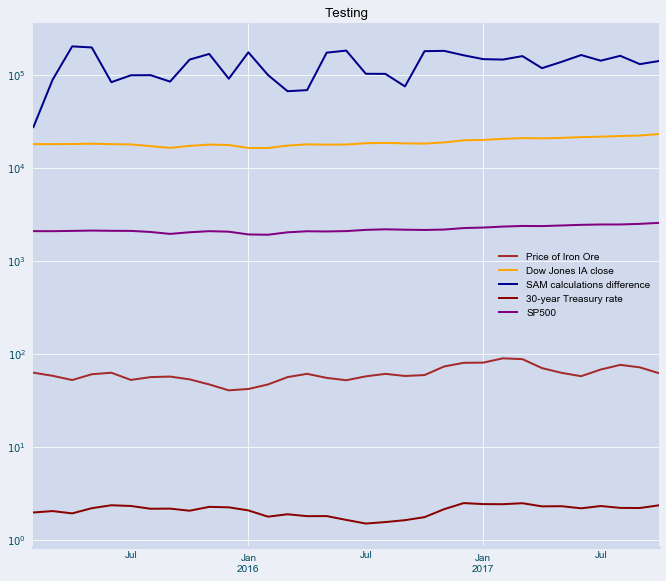

In [243]:
from plotters import plotterone

plotterone(combined)

It's hard to see any trends in that visualization.  Next, we'll look at the distributions of each data set; when dealing with a set of data, often the <a href="http://seaborn.pydata.org/tutorial/distributions.html" target="_blank">first thing you’ll want to do is get a sense for how the variables are distributed</a>. In a perfect world you will see a normally distributed data set (the bell curve): We want to see something like this:

<div class="image">
<img src="http://nationalpainreport.com/wp-content/uploads/2013/10/joy-selak-chart-500x297.jpg" height="400" width="500">
<p><center>This is a graph of a normal distribution</center></p>
</div>

Let's see what our distributions look like:

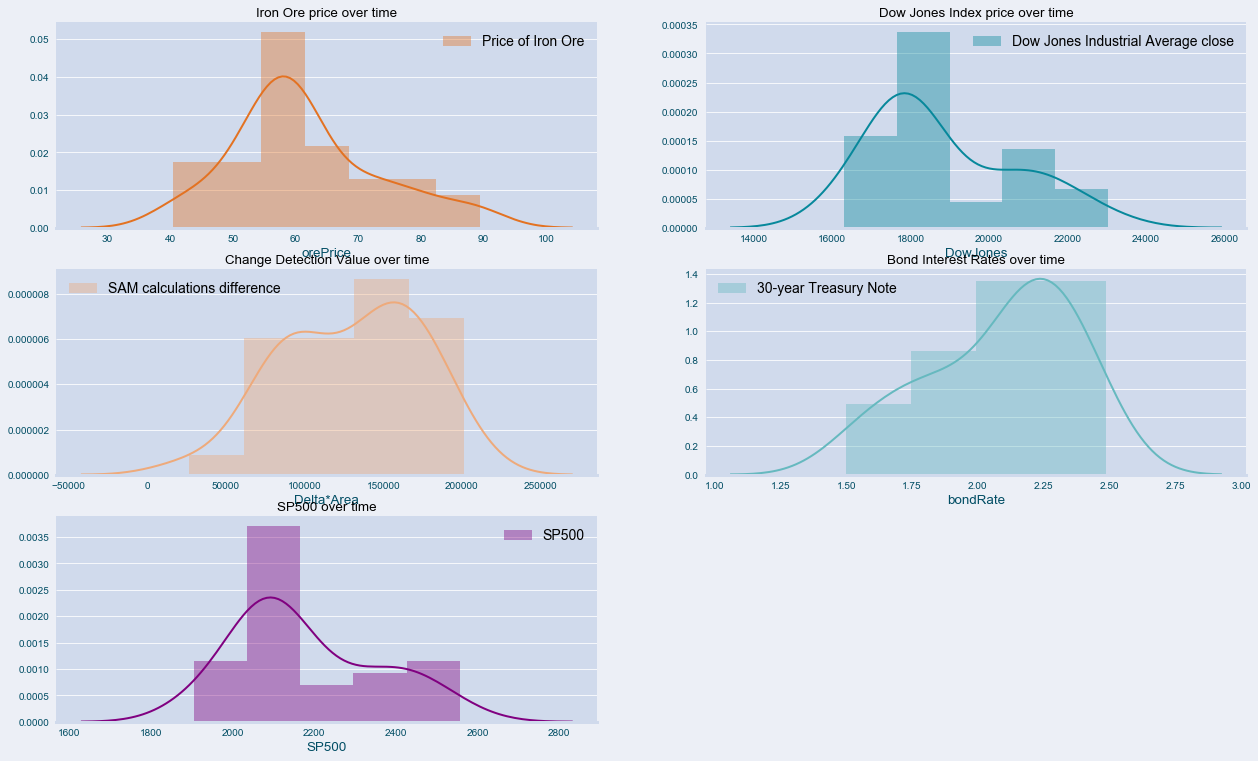

In [244]:
f = plt.subplots(figsize=(19,12))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)


###################
# first plot
###################
plt.subplot(3,2,1)
# combined.orePrice.plot(label='Price of Iron Ore',color='brown')
sns.distplot(combined.orePrice,color='#E37222',label='Price of Iron Ore')
plt.legend(fontsize=14)
plt.title('Iron Ore price over time')

###################
# second plot
###################
plt.subplot(3,2,2)
# combined['Close'].plot(label='Dow Jones IA close',color='orange')
sns.distplot(combined['DowJones'],color='#07889B',label='Dow Jones Industrial Average close')
plt.legend(fontsize=14)
plt.title('Dow Jones Index price over time')

###################
# third plot
###################
plt.subplot(3,2,3)
# combined['Delta*Area'].plot(label='SAM calculations difference',color='darkblue')
sns.distplot(combined['Delta*Area'],color="#eeAA7b",label='SAM calculations difference')
plt.legend(fontsize=14)
plt.title('Change Detection Value over time')

###################
# third plot
###################
plt.subplot(3,2,4)
# combined['bondRate'].plot(label='30-year Treasury Note',color='darkred')
sns.distplot(combined['bondRate'],color='#66b9bf',label='30-year Treasury Note')
plt.legend(fontsize=14)
plt.title('Bond Interest Rates over time')


###################
# fifth plot
###################
plt.subplot(3,2,5)
# combined['bondRate'].plot(label='30-year Treasury Note',color='darkred')
sns.distplot(combined['SP500'],color='purple',label='SP500')
plt.legend(fontsize=14)
plt.title('SP500 over time')
plt.show()

If you look at the `x-axis`, you see the distributions are all over the place.  And now we'll plot the values individually to get the nuances of the change in values over time. There are obvious peaks but the data is skewed in a few of our sets above. Let's move on to single line plots for each:

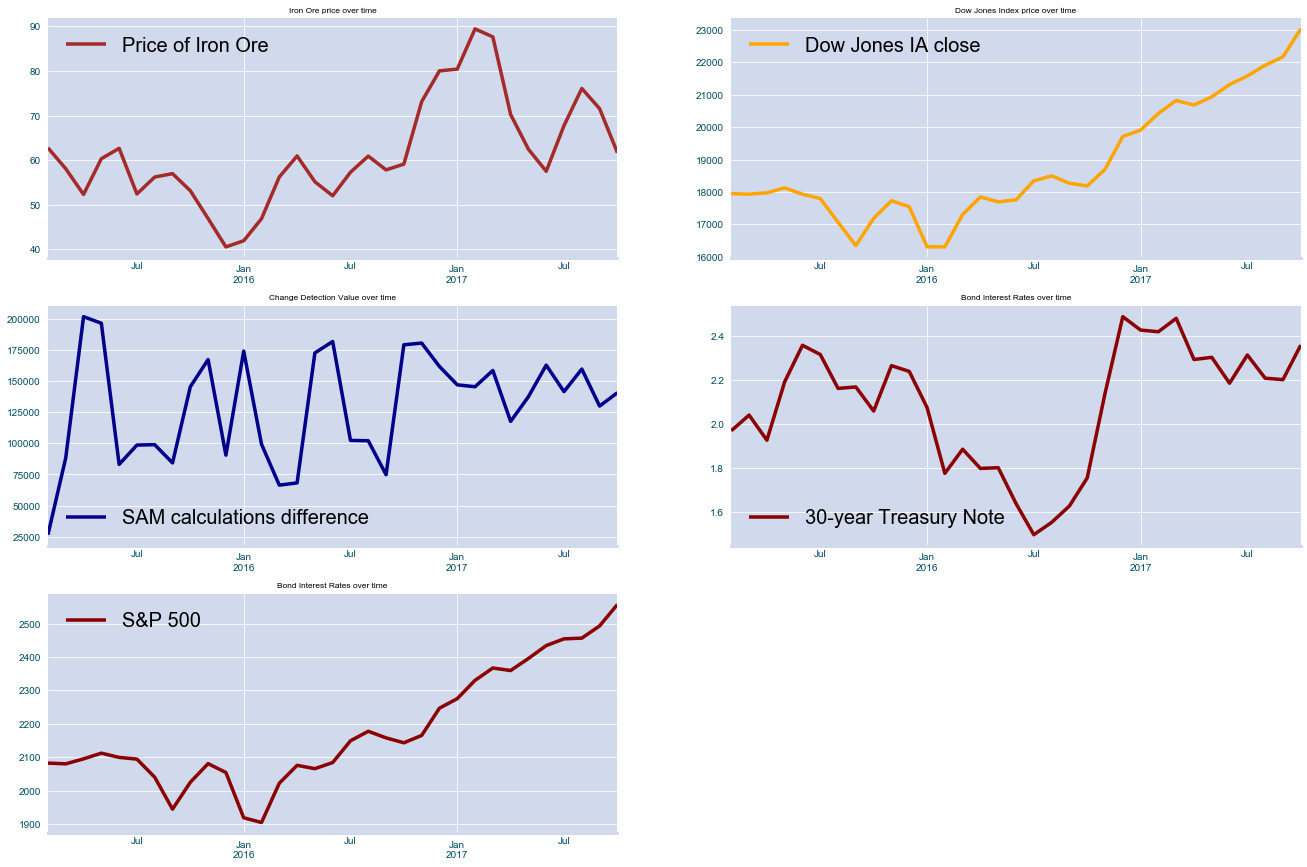

In [248]:
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
f = plt.subplots(figsize=(20,15))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)

###################
# first plot
###################
plt.subplot(3,2,1)
combined.orePrice.plot(label='Price of Iron Ore',color='brown',linewidth=3.5)
plt.legend(fontsize=20)
plt.title('Iron Ore price over time')

###################
# second plot
###################
plt.subplot(3,2,2)
combined['DowJones'].plot(label='Dow Jones IA close',color='orange',linewidth=3.5)
plt.legend(fontsize=20)
plt.title('Dow Jones Index price over time')

###################
# third plot
###################
plt.subplot(3,2,3)
combined['Delta*Area'].plot(label='SAM calculations difference',color='darkblue',linewidth=3.5)
plt.legend(fontsize=20)
plt.title('Change Detection Value over time')

###################
# fourth plot
###################
plt.subplot(3,2,4)
combined['bondRate'].plot(label='30-year Treasury Note',color='darkred',linewidth=3.5)
plt.legend(fontsize=20)
plt.title('Bond Interest Rates over time')

###################
# fifth plot
###################
plt.subplot(3,2,5)
combined['SP500'].plot(label='S&P 500',color='darkred',linewidth=3.5)
plt.legend(fontsize=20)
plt.title('Bond Interest Rates over time')
plt.show()
plt.show()

It's hard to tell anything specific, but it looks like all datasets increase shoftly after July 2017 (possibly starting in August or September).  Because of this, we have grounds to suspect <a href="https://en.wikipedia.org/wiki/Spurious_relationship" target="_blank">spurious correlation of time series data</a>.  Let's quickly compute the Person coefficient for these data sets.  To interpret correlation coefficients, <a href="http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/" target="_blank">see this page</a>.  In short, numbers closer to 1(-1) imply strong positive (negative) correlation.  The reasons for the correlations are unknown and could be from a confounding variable.  This is where domain expertise comes into play.  The correlation matrix:



In [249]:
combined.corr()

,orePrice,DowJones,Delta*Area,SP500,bondRate
orePrice,1.000000,0.648980,0.144401,0.641398,0.477913
DowJones,0.648980,1.000000,0.255107,0.995898,0.477438
Delta*Area,0.144401,0.255107,1.000000,0.252418,0.197838
SP500,0.641398,0.995898,0.252418,1.000000,0.454432
bondRate,0.477913,0.477438,0.197838,0.454432,1.000000


This matrix above tells us, as expected, that the S&P and Dow are correlated, and the US Market (Dow and S&P) and price for orePrice are moderately correlated (see 0.64 value above).  That makes sense because we would expect prices of raw materials to possibly increase as the market increases; but we would also expect to see prices increase as supply increases.  Now look at the correlation value for `Delta*Area` in the context of all other variables; it's VERY low suggesting we don't have any correlation at all. But we need to be sure, which is what we will cover in the next section.  Remember, we are doing the EXACT same thing we did for our Dow/S&P 500 test.  

In time series analysis, values measured over time can be correlated to time; that's a common value and one month on the `x-axis` in one data set is the same size as one month on the `x-axis` in another time series.  We will use the `first differences` method where you simply subtract from each value the value that came before it.  We make the changes on each data set and then show the first 10 rows of the data. I'm going the extra step and takking the sum as a percentage of the current value.



In [252]:
# name our values from SP and Dow test earlier
dowMag.name='DowJones'
spMag.name='SP500'

# differencing method
oreMag = (combined.assign(diff=combined.orePrice.diff().fillna(0))).apply(lambda x: (x['diff']/x['orePrice']),axis=1)
oreMag.name='Iron Ore Differences'
changeMag=(combined.assign(diff=combined['Delta*Area'].diff().fillna(0))).apply(lambda x: (x['diff']/x['Delta*Area']),axis=1)
changeMag.name = 'SAM Differences'
bondMag=(combined.assign(diff=combined['bondRate'].diff().fillna(0))).apply(lambda x: (x['diff']/x['bondRate']),axis=1)
bondMag.name = 'Bond Rate Differences'
newCombined = pd.concat([oreMag,dowMag,changeMag,bondMag,spMag],axis=1).dropna()
newCombined.head(10)

,Iron Ore Differences,DowJones,SAM Differences,Bond Rate Differences,SP500
Date,,,,,
2015-02-28,0.000000,0.022466,0.000000,0.000000,0.025942
2015-03-31,-0.080965,-0.000762,0.697732,0.034752,-0.001060
2015-04-30,-0.110367,0.002157,0.561603,-0.059013,0.007099
2015-05-31,0.133002,0.008508,-0.026737,0.120770,0.008088
2015-06-30,0.037203,-0.011016,-1.362153,0.070053,-0.006031
2015-07-31,-0.195457,-0.007429,0.157004,-0.017983,-0.002454
2015-08-31,0.067628,-0.042987,0.003330,-0.071012,-0.026608
2015-09-30,0.013345,-0.044164,-0.173642,0.002965,-0.049097
2015-10-31,-0.072101,0.049023,0.420169,-0.052938,0.039712


And now the summary statistics:

In [223]:
newCombined.describe()

,Iron Ore Differences,DowJones,SAM Differences,Bond Rate Differences,SP500
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,-0.006639,0.007856,-0.044169,0.002656,0.006709
std,0.112808,0.027554,0.444730,0.074978,0.024440
min,-0.248220,-0.075902,-1.362153,-0.167817,-0.070615
25%,-0.086117,-0.006689,-0.173642,-0.052938,-0.004834
50%,0.004850,0.009832,0.003330,0.000000,0.008801
75%,0.086478,0.025264,0.144488,0.055301,0.023518
max,0.191655,0.057926,0.697732,0.178742,0.058130



We see that the mean for all values is near zero (0) so we have created some similarities in the data. 

Next, we will look at the distribution of our data since our mean is zero.  Remember, in a perfect world, you will see a normally distributed data set (the bell curve) that looks something like this:

<div class="image">
<img src="http://nationalpainreport.com/wp-content/uploads/2013/10/joy-selak-chart-500x297.jpg" height="400" width="500">
<p><center>This is a graph of a normal distribution</center></p>
</div>



Here are our new distribution plots:

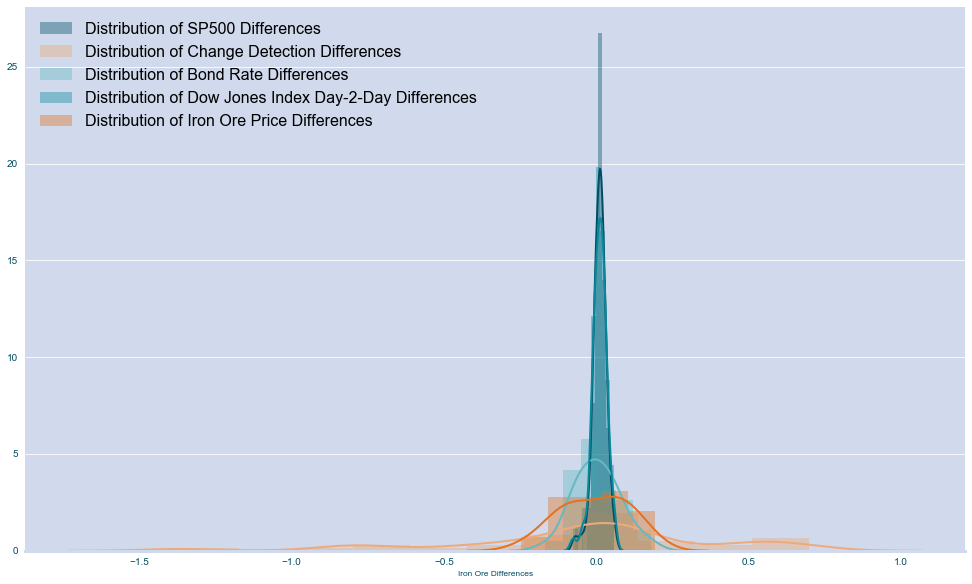

In [253]:
import seaborn as sns
f = plt.subplots(figsize=(15,10))
sns.distplot(spMag,label='Distribution of SP500 Differences'),sns.distplot(changeMag,label='Distribution of Change Detection Differences',color="#eeAA7b"),sns.distplot(bondMag,label='Distribution of Bond Rate Differences',color='#66b9bf'),sns.distplot(dowMag,label='Distribution of Dow Jones Index Day-2-Day Differences',color='#07889B'),sns.distplot(oreMag,label='Distribution of Iron Ore Price Differences',color='#E37222')
plt.legend(loc=2,fontsize=16)
plt.show()

This quick plot shows that we have roughly normal distributions centered around one (1).  Let's look at how our line plots changed 

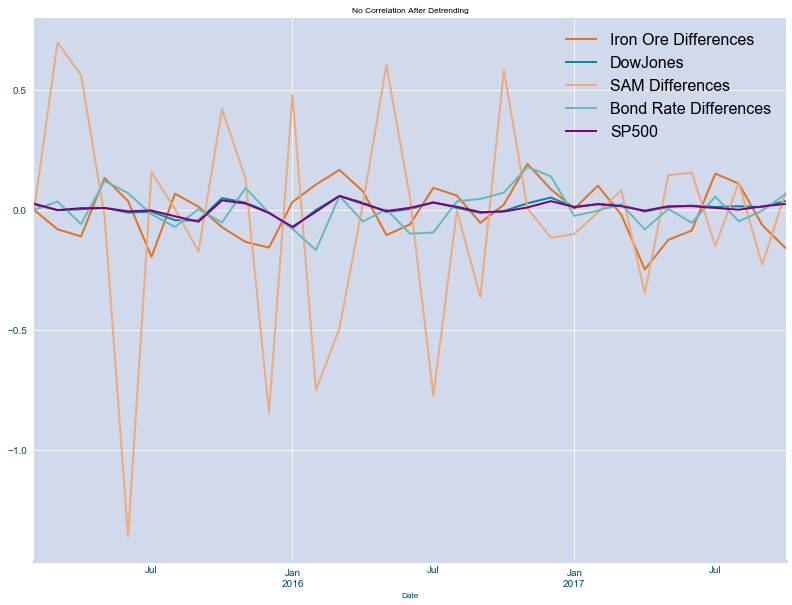

In [254]:
f,ax = plt.subplots(figsize=(12,10))
newCombined.plot(ax=ax,color=['#E37222','#07889B',"#eeAA7b",'#66b9bf','purple'])
plt.legend(fontsize=16)
plt.title('No Correlation After Detrending')
plt.show()

And finally let's recompute the correlation coefficient:

In [255]:
# pd.concat([oreMag,dowMag,changeMag,bondMag],axis=1).rename(columns={0:'Ore Price',1:"Dow Jones",2:'Change Detection',3:"Bonds"}).corr()
newCombined.corr()

,Iron Ore Differences,DowJones,SAM Differences,Bond Rate Differences,SP500
Iron Ore Differences,1.000000,0.157990,-0.214737,0.227629,0.100135
DowJones,0.157990,1.000000,-0.060793,0.317753,0.970394
SAM Differences,-0.214737,-0.060793,1.000000,0.044531,-0.068817
Bond Rate Differences,0.227629,0.317753,0.044531,1.000000,0.254727
SP500,0.100135,0.970394,-0.068817,0.254727,1.000000


As these numbers show, **SAM Differences** has no correlation to any of the data sets we used based on our test.  We also see that the Iron Ore prices correlation is not even holding when we using the differences method on the time series; but, the S&P and Dow Jones correlation holds and is still very strong.  So, what is our conclusion:

>**We do not have evidence to suggest there is a correlation between the SAM change detection data, ore price data, the SP500 or the Dow Jones**

The reason for the higher correlation earlier was `time`; ALL values changed over time.  All values increased/decreased depending on time because that was a common variable (`x-axis`) so we needed to remove that dependency.  The method we used (first-differences de-trending) is <a href="https://svds.com/avoiding-common-mistakes-with-time-series/" target="_blank">discussed in this artcle</a>.